In [1]:
from Swin_Transformer.models.swin_transformer import *

Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.


In [2]:
import torch
import torchvision.models as models

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SwinTransformer().eval().cuda()
print(device)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cuda


In [4]:
checkpoint = torch.load('swin_tiny_patch4_window7_224.pth')
checkpoint = checkpoint['model']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [5]:
torch.save(model, 'Swin_T.pth')

In [6]:
print(model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

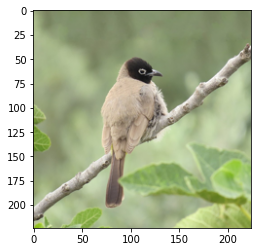

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
input_file  = "images/bulbul.jpg"
with Image.open(input_file) as img:
    img = img.resize((224,224))
    data = np.asarray(img).astype('float32') / float(255.0)
    data = np.moveaxis(data, 2, 0)
    plt.imshow(img)
input_tensor = torch.from_numpy(np.expand_dims(data, axis=0))

In [16]:
time_torch = []
total_torch = 0
with torch.no_grad():
    for i in range(0, 100):
        start_t = time.time()
        cuda_tensor = input_tensor.to("cuda")
        pred = model(cuda_tensor)
        end_t = time.time()
        time_torch.append(end_t - start_t)
        total_torch += time_torch[i]
print("average time cost:", total_torch * 10, "ms")

average time cost: 6.965548992156982 ms


In [9]:
pred.argmax()

tensor(16, device='cuda:0')

In [10]:
# TO ONNX
x = torch.randn((1, 3, 224, 224)).cuda()

In [11]:
torch.onnx.export(model, x, "Swin_T_window_process.onnx", verbose=True, opset_version=11, export_params=True, input_names = ['input'], output_names = ['output'])

/workspace/sdd_sony/Pytorch/Swin_Transformer/models/swin_transformer.py:470: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H == self.img_size[0] and W == self.img_size[1], \
/workspace/sdd_sony/Pytorch/Swin_Transformer/models/swin_transformer.py:251: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/workspace/sdd_sony/Pytorch/Swin_Transformer/models/swin_transformer.py:55: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward

graph(%input : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %patch_embed.proj.weight : Float(96, 3, 4, 4, strides=[48, 16, 4, 1], requires_grad=1, device=cuda:0),
      %patch_embed.proj.bias : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %patch_embed.norm.weight : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %patch_embed.norm.bias : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %layers.0.blocks.0.norm1.weight : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %layers.0.blocks.0.norm1.bias : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %layers.0.blocks.0.attn.qkv.bias : Float(288, strides=[1], requires_grad=1, device=cuda:0),
      %layers.0.blocks.0.attn.proj.bias : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %layers.0.blocks.0.norm2.weight : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %layers.0.blocks.0.norm2.bias : Float

In [1]:
import onnx
from onnx import shape_inference

In [31]:
model = r'Swin_T.onnx'
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(model)), model)

In [3]:
model = onnx.load ('transfusion_head_sim.onnx')
onnx.checker.check_model(model) 

In [9]:
import os

logger = trt.Logger(trt.Logger.WARNING)
runtime = trt.Runtime(logger)
trt.init_libnvinfer_plugins(logger, "")
engine_file = "transfusion_head.engine"
assert os.path.exists(engine_file)
print("Reading engine from file {}".format(engine_file))
with open(engine_file, "rb") as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Reading engine from file transfusion_head.engine


In [10]:
print(engine)

In [1]:
import tensorrt as trt

In [2]:
logger = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(logger)
trt.init_libnvinfer_plugins(logger, "")

True

In [3]:
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))

In [4]:
# parser for onnx model
parser = trt.OnnxParser(network, logger)

In [5]:
# INT64 to INT32
# ! python -m onnxsim Swin_T.onnx Swin_T32.onnx

In [6]:
model_path = r'trans_modified1.onnx'
success = parser.parse_from_file(model_path)
for idx in range(parser.num_errors):
    print(parser.get_error(idx))
print(success)

True


In [7]:
config = builder.create_builder_config()
# config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 20) # 1 MiB
serialized_engine = builder.build_serialized_network(network, config)

In [8]:
with open("transfusion_head.engine", "wb") as f:
    f.write(serialized_engine)

In [9]:
# Inference
runtime = trt.Runtime(logger)
engine = runtime.deserialize_cuda_engine(serialized_engine)
# context = engine.create_execution_context()

In [10]:
# For transfusion_head
def infer_metas(engine, input_file):

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        # context.set_binding_shape(engine.get_binding_index("input"), (1, 512, 180, 180))
        # Allocate host and device buffers
        bindings = []
        outputs_host = []
        outputs_device = []
        output_size = 0
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_file)
                input_memory = cuda.mem_alloc(input_buffer.nbytes) # I made one change
                bindings.append(int(input_memory))
                print("input:",binding,binding_idx,size,dtype)
            else:
                output_size = output_size + size
                output_buffer = cuda.pagelocked_empty(size, dtype) # Host mem
                output_memory = cuda.mem_alloc(output_buffer.nbytes) # Device mem
                bindings.append(int(output_memory))
                outputs_host.append(output_buffer)
                outputs_device.append(output_memory)
                print("output:",binding,binding_idx,size,dtype)
        time_trt = []
        total_trt = 0
        for i in range (0, 100):
            stream = cuda.Stream()
            start_t = time.time()
            # Transfer input data to the GPU.
            cuda.memcpy_htod_async(input_memory, input_buffer, stream)
            # Run inference
            context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
            # Transfer prediction output from the GPU.
            for j in range(0, len(outputs_device)):
                cuda.memcpy_dtoh_async(outputs_host[j], outputs_device[j], stream)
            # Synchronize the stream
            stream.synchronize()
            end_t = time.time()
            time_trt.append(end_t - start_t)
            total_trt += time_trt[i]
        print(time_trt[:10])
        print("average time cost:", total_trt * 10, "ms")

    return outputs_host

In [11]:
# For Swin_T
def infer_image(engine, input_file):
    # print("Reading input image from file {}".format(input_file))
    with Image.open(input_file) as img:
        img = img.resize((224,224)) # for specific model
        input_image = preprocess(img)
        image_width = img.width
        image_height = img.height

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), (1, 3, image_height, image_width))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_buffer.nbytes) # I made one change
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))
        time_trt = []
        total_trt = 0
        for i in range (0, 100):
            stream = cuda.Stream()
            start_t = time.time()
            # Transfer input data to the GPU.
            cuda.memcpy_htod_async(input_memory, input_buffer, stream)
            # Run inference
            context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
            # Transfer prediction output from the GPU.
            cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
            # Synchronize the stream
            stream.synchronize()
            end_t = time.time()
            time_trt.append(end_t - start_t)
            total_trt += time_trt[i]
        print(time_trt[:10])
        print("average time cost:", total_trt * 10, "ms")

    return output_buffer

In [12]:
def preprocess(image):
    # Mean normalization
    # mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    # stddev = np.array([0.229, 0.224, 0.225]).astype('float32')
    # data = (np.asarray(image).astype('float32') / float(255.0) - mean) / stddev
    # Switch from HWC to to CHW order
    # return np.moveaxis(data, 2, 0)
    data = np.asarray(image).astype('float32') / float(255.0)
    return np.moveaxis(data, 2, 0)

In [13]:
# For transfusion_head
import torch
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import time

head_metas = torch.load('head_metas.pt').cpu()
input_metas = head_metas.detach().numpy()

result = infer_metas(engine, input_metas)

input: input.1 0 16588800 <class 'numpy.float32'>
output: 125 1 324000 <class 'numpy.float32'>
output: topk_values 2 200 <class 'numpy.float32'>
output: topk_indices 3 200 <class 'numpy.int32'>
output: 609 4 2000 <class 'numpy.float32'>
output: 611 5 200 <class 'numpy.float32'>
output: 612 6 600 <class 'numpy.float32'>
output: 613 7 400 <class 'numpy.float32'>
output: 614 8 400 <class 'numpy.float32'>
output: 615 9 2000 <class 'numpy.float32'>
output: 610 10 400 <class 'numpy.float32'>
[0.03230023384094238, 0.01703643798828125, 0.016898632049560547, 0.016889333724975586, 0.016976356506347656, 0.017724990844726562, 0.015923261642456055, 0.015676498413085938, 0.01564168930053711, 0.015628576278686523]
average time cost: 15.53398609161377 ms


In [20]:
print(result[9])

[ 20.543236   10.544364   20.53587    57.429466   18.672396   11.646322
  86.39738    91.4855    132.5144    103.54572    12.630223   49.724945
  76.37881   101.85127    19.493378   47.50386    17.174152   11.054919
  12.364813   57.440735   14.474374  101.55739    18.84857    19.750654
  13.233294   64.56557    16.256239    9.51982    28.65275    58.681667
  11.377809    5.400988   53.325916    9.658897  110.23586    16.266914
  34.553005   70.85452     7.2172832  47.63442    16.366432   69.47062
  81.29295    16.168997    7.05346   102.21612    59.183125   81.309135
  47.50633    20.369265    9.305943    9.538515   20.281738   22.476185
  81.36619    55.221233   17.846592   13.830679   46.708023   86.40784
  83.21894    21.514078  101.49793   119.324814   69.65016   100.56707
  21.964771   19.330362   18.678183   12.205064   61.712975   13.711173
  75.261696   55.657      52.559494   12.064835   19.525867  100.85688
  47.435055  101.71742    50.305893   61.14659     6.445466   61.764

In [16]:
# For Swin_T
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import time
import matplotlib.pyplot as plt
from PIL import Image

input_file  = "images/bulbul.jpg"
result = infer_image(engine, input_file)

[0.8616974353790283, 0.003162860870361328, 0.0031516551971435547, 0.003155946731567383, 0.003153085708618164, 0.0031495094299316406, 0.0031239986419677734, 0.003117084503173828, 0.0031232833862304688, 0.003178119659423828]
average time cost: 11.530485153198242 ms


In [19]:
print(np.argmax(result))

16
